# CLUSTERIZAÇÃO VARIÁVEIS SINTÉTICAS DE NÍVEL DE DESENVOLVIMENTO DO MUNICÍPIO

CNAE_FISCAL_PRINCIPAL - MUNICÍPIO - CONTAGEM_CP_MUN

In [1]:
import pandas as pd
df = pd.read_csv('df_final_cp.csv')
df

,DATA_DE_INÍCIO_ATIVIDADE,CNAE_FISCAL_PRINCIPAL,MUNICÍPIO
0,2023,4712100,3849
1,2023,4321500,5453
2,2023,8599604,8877
3,2023,4617600,9051
4,2023,8230001,7225
...,...,...,...
56520613,1901,8411600,3473
56520614,1899,6462000,7107
56520615,1893,8413200,4123
56520616,1891,1321900,4675


In [2]:
# CONTAGEM_CP_MUN
# criando a coluna contagem para o ranking: 
# CONTAGEM_CP_MUN = total de CNAE_FISCAL_PRINCIPAL em cada município
# pilhagem com repetição -> mesmos cnaes abertos + de 1x

df['CONTAGEM_CP_MUN'] = df.groupby('MUNICÍPIO')['CNAE_FISCAL_PRINCIPAL'].transform('count')

# ordenando a coluna contagem para o ranking:

df = df.sort_values('CONTAGEM_CP_MUN', ascending=False)
df

,DATA_DE_INÍCIO_ATIVIDADE,CNAE_FISCAL_PRINCIPAL,MUNICÍPIO,CONTAGEM_CP_MUN
48313210,1993,4761003,7107,5000344
47549820,1994,4729601,7107,5000344
47549810,1994,4637101,7107,5000344
5722868,2021,4520001,7107,5000344
5722866,2021,3299006,7107,5000344
...,...,...,...,...
44279756,1999,9492800,390,210
22920262,2016,9492800,390,210
45981331,1997,8411600,390,210
10252843,2020,4120400,390,210


In [3]:
# EXCLUINDO AS INFORMAÇÕES NÃO NECESSÁRIAS AO MODELO:
df = df.drop(['DATA_DE_INÍCIO_ATIVIDADE'], axis=1)
df

,CNAE_FISCAL_PRINCIPAL,MUNICÍPIO,CONTAGEM_CP_MUN
48313210,4761003,7107,5000344
47549820,4729601,7107,5000344
47549810,4637101,7107,5000344
5722868,4520001,7107,5000344
5722866,3299006,7107,5000344
...,...,...,...
44279756,9492800,390,210
22920262,9492800,390,210
45981331,8411600,390,210
10252843,4120400,390,210


In [4]:
dados_cluster = df[['CNAE_FISCAL_PRINCIPAL', 'MUNICÍPIO', 'CONTAGEM_CP_MUN']]
dados_cluster

,CNAE_FISCAL_PRINCIPAL,MUNICÍPIO,CONTAGEM_CP_MUN
48313210,4761003,7107,5000344
47549820,4729601,7107,5000344
47549810,4637101,7107,5000344
5722868,4520001,7107,5000344
5722866,3299006,7107,5000344
...,...,...,...
44279756,9492800,390,210
22920262,9492800,390,210
45981331,8411600,390,210
10252843,4120400,390,210


In [5]:
# Realize a amostragem aleatória simples com 0,01% dos dados
dados_cluster = dados_cluster.sample(frac=0.0001, random_state=42)
dados_cluster

,CNAE_FISCAL_PRINCIPAL,MUNICÍPIO,CONTAGEM_CP_MUN
53157702,9312300,8869,18133
33237775,113000,7221,7464
33583583,4520005,8057,19348
46061382,4755502,1537,11980
12878269,9492800,7885,103123
...,...,...,...
47664523,4784900,6291,443282
29489123,9499500,6707,22534
48695380,4781400,3,136138
8900587,4781400,9403,10086


In [6]:
# transformações necessárias para aplicação do algoritmo
# Converter as colunas "MUNICÍPIO" e "CNAE_FISCAL_PRINCIPAL" em string
dados_cluster["MUNICÍPIO"] = dados_cluster["MUNICÍPIO"].astype(str)
dados_cluster["CNAE_FISCAL_PRINCIPAL"] = dados_cluster["CNAE_FISCAL_PRINCIPAL"].astype(str)

# Agrupar o DataFrame pelos campos desejados
grupo = dados_cluster.groupby(["CONTAGEM_CP_MUN", "MUNICÍPIO", "CNAE_FISCAL_PRINCIPAL"]).size().reset_index(name="Contagem")

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dados_cluster_scaled = scaler.fit_transform(grupo)

pca = PCA(n_components=2)  # k é o número de componentes principais desejados
X = pca.fit_transform(dados_cluster_scaled)

componentes_principais = pca.components_
variancia_explicada = pca.explained_variance_ratio_


Número de clusters encontrados: 9


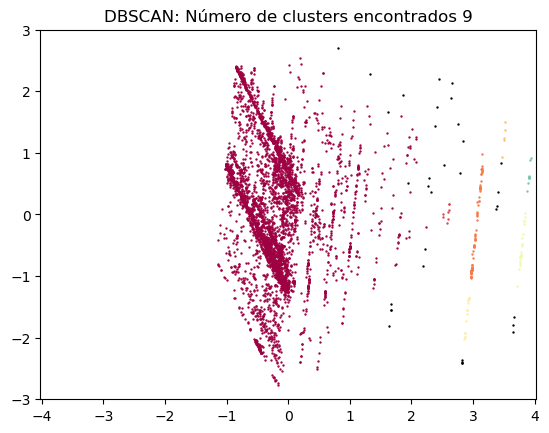

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Aplicando o DBSCAN
eps = 0.3  # Parâmetro de distância máxima entre os pontos do mesmo cluster
min_samples = 5  # Número mínimo de pontos para formar um cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Obtendo a quantidade de clusters encontrados
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Número de clusters encontrados: {n_clusters}")

# Criando um gráfico colorido dos clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Ruído é exibido em preto
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker='o', s=0.5)

plt.title('DBSCAN: Número de clusters encontrados {}'.format(n_clusters))

# Centralizar o gráfico na origem
plt.axis('equal')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()
